# Grid Search using the whole Human Data

## Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Get data source.
simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0817_0630_selection_results.csv"
human_duration_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection duration.csv"
human_error_rate_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection error rate.csv"

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [2]:
human_duration_data, len(human_duration_data), len(human_duration_data[0])

([[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
  [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
  [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]],
 3,
 12)

In [12]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Grid Search with the Loss Function of Summed Abs Difference

In [4]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

# Get the mean values
mean_human_duration = [np.mean(data) for data in human_duration_data]
mean_human_error = [np.mean(data) for data in human_error_data]

# Normalize the human data
human_duration_norm = normalize(mean_human_duration)
human_error_norm = normalize(mean_human_error)

# Iterate through each unique parameter combination
unique_params = df_simulations.drop(columns=['layout', 'steps', 'error']).drop_duplicates()

min_cost = float('inf')
best_params = None

for index, row in unique_params.iterrows():
    # Filter the dataframe for the specific parameter combination
    filtered_df = df_simulations[
        (df_simulations['init_delta_t'] == row['init_delta_t']) &
        (df_simulations['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
        (df_simulations['weight_memory_decay'] == row['weight_memory_decay']) &
        (df_simulations['spatial_dist_coeff'] == row['spatial_dist_coeff'])
    ]
    
    sim_duration = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
    sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
    
    # Normalize the simulated data
    sim_duration_norm = normalize(sim_duration)
    sim_error_norm = normalize(sim_error)
    
    # Compute the cost
    cost_duration = compute_cost(sim_duration_norm, human_duration_norm)
    cost_error = compute_cost(sim_error_norm, human_error_norm)
    total_cost = cost_duration + cost_error

    # Update the best parameters if this cost is lower
    if total_cost < min_cost:
        min_cost = total_cost
        best_params = row
        
print("Best parameters:", best_params)

Best parameters: init_delta_t                  3.5
init_sigma_position_memory    0.5
weight_memory_decay           0.6
spatial_dist_coeff            2.5
Name: 6975, dtype: float64


## Get a sim-to-real-mapping-parameter to fit human data and Plot

In [5]:
# Using best_params, get the simulation data for steps and errors for the best parameters
best_df = df_simulations[
    (df_simulations['init_delta_t'] == best_params['init_delta_t']) &
    (df_simulations['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
    (df_simulations['weight_memory_decay'] == best_params['weight_memory_decay']) &
    (df_simulations['spatial_dist_coeff'] == best_params['spatial_dist_coeff'])
]

sim_duration_best = [best_df[best_df['layout'] == layout]['steps'].values[0] for layout in layouts]
sim_error_best = [best_df[best_df['layout'] == layout]['error'].values[0] for layout in layouts]

sim_to_real_ratio_duration = sum(mean_human_duration) / sum(sim_duration_best)
sim_to_real_ratio_error = sum(mean_human_error) / sum(sim_error_best)

In [6]:
sim_duration_best

[10.56, 8.24, 6.72]

In [7]:
sim_to_real_ratio_duration, sim_to_real_ratio_error

(0.15082941483803552, 6.6108757062146895)

In [8]:
# Plot individual level data
import matplotlib.pyplot as plt

# Read in individual data
individual_data = r"C:\Users\91584\Desktop\0817_0630_selection_individual_data.csv"
individual_df = pd.read_csv(individual_data)

In [33]:
def extract_data(df, params, col_name, layouts):
    # Filter the dataframe based on the provided params
    for key, value in params.items():
        if isinstance(value, float):
            df = df[np.isclose(df[key], value, atol=1e-8)]
        else:
            df = df[df[key] == value]
    
    data = []
    for layout in layouts:
        subset = df[df['layout'] == layout][col_name].tolist()
        data.append(subset)
    return data

# Function to calculate means and standard error of the mean
def calculate_mean_and_sem(data):
    means = [np.mean(d) for d in data]
    sems = [np.std(d) / np.sqrt(len(d)) for d in data]
    return means, sems

def plot_comparison_bars(sim_means, sim_sems, human_means, human_sems, title_prefix=""):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    x_labels = ["L0", "L50", "L100"]
    x = np.arange(len(x_labels))
    bar_width = 0.25

    # Plotting for Duration
    axs[0].bar(x - bar_width/2, sim_means[0], yerr=sim_sems[0], color='blue', width=bar_width, label='Simulator', capsize=5)
    axs[0].bar(x + bar_width/2, human_means[0], yerr=human_sems[0], color='orange', width=bar_width, label='Human', capsize=5)
    
    # Annotating Duration Bars
    for i, rect in enumerate(axs[0].patches):
        height = rect.get_height()
        if i < len(x_labels):
            sem = sim_sems[0][i]
        else:
            sem = human_sems[0][i-len(x_labels)]
        axs[0].annotate(f"{height:.2f}\n({sem:.2f})", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Duration
    axs[0].set_xlabel("Layouts", fontsize=12)
    axs[0].set_ylabel(f"{title_prefix} Duration Across Different Layouts (s)", fontsize=12)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(x_labels)
    axs[0].legend()

    # Plotting for Error Rate
    axs[1].bar(x - bar_width/2, sim_means[1], yerr=sim_sems[1], color='blue', width=bar_width, label='Simulator', capsize=5)
    axs[1].bar(x + bar_width/2, human_means[1], yerr=human_sems[1], color='orange', width=bar_width, label='Human', capsize=5)
    
    # Annotating Error Bars
    for i, rect in enumerate(axs[1].patches):
        height = rect.get_height()
        if i < len(x_labels):
            sem = sim_sems[1][i]
        else:
            sem = human_sems[1][i-len(x_labels)]
        axs[1].annotate(f"{height:.2f}%\n({sem:.2f}%)", 
                       (rect.get_x() + rect.get_width() / 2., height + sem + 0.05),
                       ha='center', va='bottom')

    # Styling for Error Rate
    axs[1].set_xlabel("Layouts", fontsize=12)
    axs[1].set_ylabel(f"{title_prefix} Error Rate Across Different Layouts (%)", fontsize=12)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(x_labels)
    axs[1].legend()
    
    # After plotting and annotating Duration bars, adjust the y-limit
    adjust_ylim(axs[0], sim_duration_mean + human_duration_mean, sim_duration_sem + human_duration_sem)

    # After plotting and annotating Error Rate bars, adjust the y-limit
    adjust_ylim(axs[1], sim_error_mean + human_error_mean, sim_error_sem + human_error_sem)


    plt.tight_layout()
    plt.show()

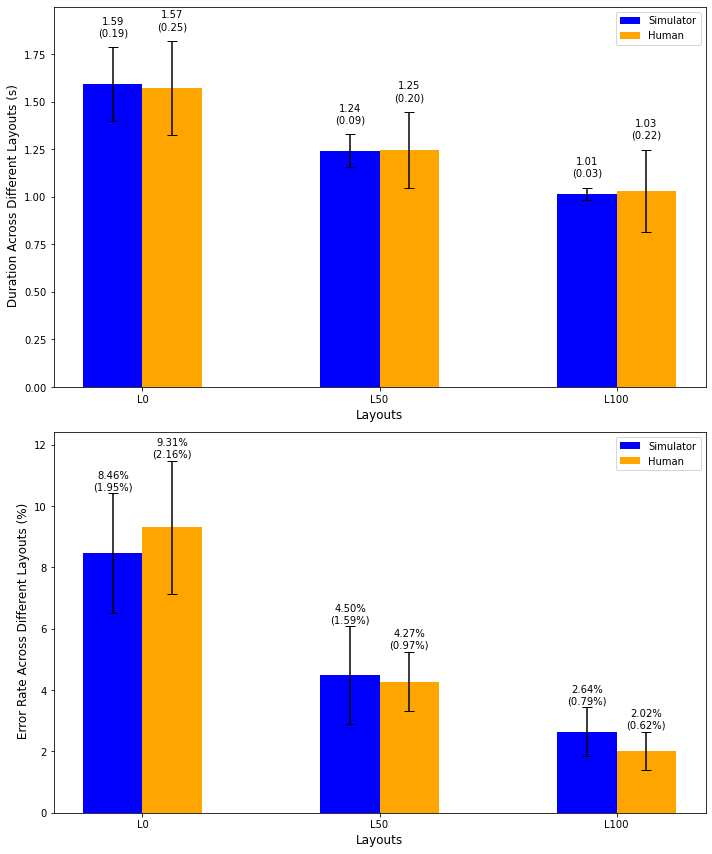

In [32]:
# Extract the data for each agent
simulation_durations = extract_data(individual_df, best_params, 'steps', layouts)
simulation_errors = extract_data(individual_df, best_params, 'error', layouts)
sim_durations = [[item * sim_to_real_ratio_duration for item in sublist] for sublist in simulation_durations]
sim_errors = [[item * sim_to_real_ratio_error for item in sublist] for sublist in simulation_errors]

sim_duration_mean, sim_duration_sem = calculate_mean_and_sem(sim_durations)
sim_error_mean, sim_error_sem = calculate_mean_and_sem(sim_errors)
human_duration_mean, human_duration_sem = calculate_mean_and_sem(human_duration_data)
human_error_mean, human_error_sem = calculate_mean_and_sem(human_error_data)

# Plot
plot_comparison_bars([sim_duration_mean, sim_error_mean], 
                     [sim_duration_sem, sim_error_sem], 
                     [human_duration_mean, human_error_mean], 
                     [human_duration_sem, human_error_sem])

## Comparison between human data and model's predictions - Need to downsample the simulated results

In [17]:
# Function to randomly select 12 indices from a list and sample from that list using those indices
def sample_twelve_indices(data):
    indices = np.arange(len(data))
    sampled_indices = np.random.choice(indices, 12, replace=False)
    return [data[i] for i in sampled_indices]

# Sample 12 items from sim_durations and sim_errors for each layout
sampled_sim_durations = []
sampled_sim_errors = []

for duration_subset, error_subset in zip(sim_durations, sim_errors):
    indices = np.arange(len(duration_subset))
    if len(indices) > 12:
        sampled_indices = np.random.choice(indices, 12, replace=False)
    else:
        sampled_indices = indices

    sampled_sim_durations.append([duration_subset[i] for i in sampled_indices])
    sampled_sim_errors.append([error_subset[i] for i in sampled_indices])

print(sampled_sim_durations)
print(sampled_sim_errors)

def compute_rmse(true_data, pred_data):
    assert len(true_data) == len(pred_data), "Data lengths must match"
    squared_errors = [(true - pred)**2 for true, pred in zip(true_data, pred_data)]
    return np.sqrt(np.mean(squared_errors))

# Assuming human_duration_data and human_error_data are the true values

rmse_durations = [compute_rmse(human, sim) for human, sim in zip(human_duration_data, sampled_sim_durations)]
rmse_errors = [compute_rmse(human, sim) for human, sim in zip(human_error_data, sampled_sim_errors)]

print("\n")
print("RMSE for Durations:", rmse_durations)
print("RMSE for Errors:", rmse_errors)

[[0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 7.541470741901776], [0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 1.5082941483803554, 1.5082941483803554, 1.5082941483803554, 0.9049764890282131, 2.7149294670846396], [0.9049764890282131, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 1.5082941483803554, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131, 0.9049764890282131]]
[[0.0, 0.0, 0.0, 19.83262711864407, 33.054378531073446, 0.0, 0.0, 26.443502824858758, 0.0, 0.0, 0.0, 39.66525423728814], [13.221751412429379, 19.83262711864407, 0.0, 0.0, 6.6108757062146895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 6.6108757062146895, 0.0, 6.6108

## Comparison between human data and simulated results - Boostrapped

3 50
Bootstrapped RMSE for Durations: [1.9011334338148735, 1.054196566821754, 0.6338900704533129]
Bootstrapped RMSE for Errors: [14.346173514591715, 12.081788980616011, 5.662947092361292]


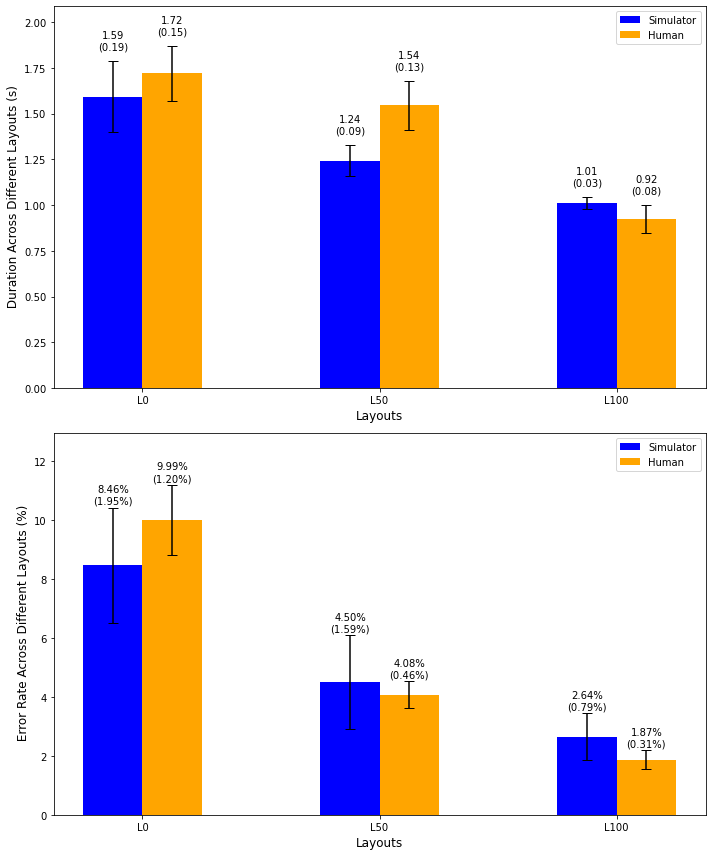

In [34]:
def bootstrap_resample(data, n):
    """ Bootstrap resample the data to have n points. """
    return np.random.choice(data, n, replace=True)

# Bootstrapping human data to match the length of simulated data
bootstrapped_human_durations = [bootstrap_resample(human, len(sim)) for human, sim in zip(human_duration_data, sim_durations)]
bootstrapped_human_errors = [bootstrap_resample(human, len(sim)) for human, sim in zip(human_error_data, sim_errors)]

print(len(bootstrapped_human_durations), len(bootstrapped_human_durations[0]))

# Computing RMSE for the bootstrapped data
rmse_durations_bootstrap = [compute_rmse(human, sim) for human, sim in zip(bootstrapped_human_durations, sim_durations)]
rmse_errors_bootstrap = [compute_rmse(human, sim) for human, sim in zip(bootstrapped_human_errors, sim_errors)]

print("Bootstrapped RMSE for Durations:", rmse_durations_bootstrap)
print("Bootstrapped RMSE for Errors:", rmse_errors_bootstrap)

# Plot
# Extract the data for each agent
sim_duration_mean, sim_duration_sem = calculate_mean_and_sem(sim_durations)
sim_error_mean, sim_error_sem = calculate_mean_and_sem(sim_errors)
human_duration_mean, human_duration_sem = calculate_mean_and_sem(bootstrapped_human_durations)
human_error_mean, human_error_sem = calculate_mean_and_sem(bootstrapped_human_errors)

# Plot
plot_comparison_bars([sim_duration_mean, sim_error_mean], 
                     [sim_duration_sem, sim_error_sem], 
                     [human_duration_mean, human_error_mean], 
                     [human_duration_sem, human_error_sem])

## Comparison between human data and simulated results - Aggregated mean and variance

In [24]:
def aggregate_comparison(human_data, simulated_data):
    # Compute aggregate metrics for human data
    human_mean = [np.mean(data) for data in human_data]
    human_sem = [np.std(data) / np.sqrt(len(data)) for data in human_data]

    # Compute aggregate metrics for simulated data
    simulated_mean = [np.mean(data) for data in simulated_data]
    simulated_sem = [np.std(data) / np.sqrt(len(data)) for data in simulated_data]

    return human_mean, human_sem, simulated_mean, simulated_sem

human_mean_duration, human_sem_duration, sim_mean_duration, sim_sem_duration = aggregate_comparison(human_duration_data, sim_durations)
human_mean_error, human_sem_error, sim_mean_error, sim_sem_error = aggregate_comparison(human_error_data, sim_errors)

print("Human vs Simulated Duration Mean:", human_mean_duration, sim_mean_duration)
print("Human vs Simulated Duration SEM:", human_sem_duration, sim_sem_duration)
print("Human vs Simulated Error Mean:", human_mean_error, sim_mean_error)
print("Human vs Simulated Error SEM:", human_sem_error, sim_sem_error)

Human vs Simulated Duration Mean: [1.5716666666666665, 1.2458333333333333, 1.0316666666666665] [1.5927586206896551, 1.242834378265413, 1.013573667711599]
Human vs Simulated Duration SEM: [0.24678722654380883, 0.19933729905939906, 0.21577970161632354] [0.19306919231613878, 0.08559459657640764, 0.032779642596439444]
Human vs Simulated Error Mean: [9.310833333333335, 4.2749999999999995, 2.015833333333333] [8.461920903954802, 4.495395480225989, 2.644350282485876]
Human vs Simulated Error SEM: [2.1608458536510056, 0.9680145057453083, 0.6235577340432762] [1.952526364653395, 1.5914507609254487, 0.7933050847457629]


## Comparison between human data and simulated results - Aggregated mean and variance

In [23]:
from scipy.stats import ks_2samp

def distribution_comparison(human_data, simulated_data):
    ks_statistic = []
    p_value = []

    for h_data, s_data in zip(human_data, simulated_data):
        ks_stat, p_val = ks_2samp(h_data, s_data)
        ks_statistic.append(ks_stat)
        p_value.append(p_val)

    return ks_statistic, p_value

ks_stat_duration, p_val_duration = distribution_comparison(human_duration_data, sim_durations)
ks_stat_error, p_val_error = distribution_comparison(human_error_data, sim_errors)

print("KS Statistic for Durations:", ks_stat_duration)
print("P-Value for Durations:", p_val_duration)
print("KS Statistic for Errors:", ks_stat_error)
print("P-Value for Errors:", p_val_error)

KS Statistic for Durations: [0.5166666666666667, 0.3333333333333333, 0.5833333333333334]
P-Value for Durations: [0.00644832985716548, 0.18442165557723567, 0.001199439791671808]
KS Statistic for Errors: [0.66, 0.6566666666666666, 0.5733333333333334]
P-Value for Errors: [0.0001273957725735908, 0.00016090361385778795, 0.0017484040152246916]


### Results explanation
The results of the Kolmogorov-Smirnov (KS) test give you both a test statistic (KS Statistic) and a corresponding p-value (P-Value). Here's how to interpret them:

1. KS Statistic:
The KS statistic represents the maximum difference between the cumulative distributions of the two datasets. Higher values of the KS statistic suggest that the two datasets are more dissimilar, while lower values suggest the datasets are more similar.

2. P-Value:
The p-value is a measure of the evidence against the null hypothesis. The null hypothesis of the KS test is that the two datasets come from the same continuous distribution.

A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis. This means there's significant evidence that the distributions are different.

A large p-value suggests that the observed data is consistent with the null hypothesis, and there's no significant evidence to suggest the distributions are different.

Interpretation of Your Results:
Durations:
Layout 1: KS Statistic = 0.5167, P-Value = 0.0064: This suggests a significant difference between the human and simulated duration distributions.

Layout 2: KS Statistic = 0.3333, P-Value = 0.1844: The difference between the distributions is less pronounced than in Layout 1, and the p-value indicates that the difference is not statistically significant.

Layout 3: KS Statistic = 0.5833, P-Value = 0.0012: This again suggests a significant difference between the human and simulated duration distributions.

Errors:
Layout 1: KS Statistic = 0.66, P-Value = 0.00013: There's a significant difference between the human and simulated error distributions.

Layout 2: KS Statistic = 0.6567, P-Value = 0.00016: Again, there's a significant difference between the distributions.

Layout 3: KS Statistic = 0.5733, P-Value = 0.0017: There's still a significant difference between the two distributions.

Overall:
For most of the layouts, there's a statistically significant difference between the human data and the simulated data, both in durations and errors. Only for Layout 2 durations, the difference is not statistically significant. This suggests that while your model might be capturing some aspects of human behavior, there are still notable differences between the simulated and human data in the conditions tested.

# Grid Search using 50% Human Data, then Evaluate on other half

## Read Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Get data source.
simulated_results = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\0817_0630_selection_results.csv"
human_duration_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection duration.csv"
human_error_rate_data = r"D:\Users\91584\PycharmProjects\uitb-headsup-computing\huc\envs\mobile_reading\results\human data\word selection error rate.csv"

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [25]:
human_duration_data

[[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
 [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
 [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]]

In [26]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Halve the human data into two parts - training and evaluation

In [27]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

def find_best_params(data, human_duration, human_error):
    unique_params = data.drop(columns=['layout', 'steps', 'error']).drop_duplicates()
    min_cost = float('inf')
    best_params = None

    for index, row in unique_params.iterrows():
        filtered_df = data[
            (data['init_delta_t'] == row['init_delta_t']) &
            (data['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == row['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == row['spatial_dist_coeff'])
        ]
        
        sim_steps = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
        sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
        
        cost_steps = compute_cost(normalize(sim_steps), normalize(human_duration))
        cost_error = compute_cost(normalize(sim_error), normalize(human_error))
        
        total_cost = cost_steps + cost_error

        if total_cost < min_cost:
            min_cost = total_cost
            best_params = row
    
    # Given the best parameters and teh dataframe, return the simulated steps (durations) and errors for the three layouts
    sim_steps_best = []
    sim_errors_best = []
    
    # Extract the simulated steps and error for each layout based on best_params
    for layout in layouts:
        filtered_df = data[
            (data['init_delta_t'] == best_params['init_delta_t']) &
            (data['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == best_params['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == best_params['spatial_dist_coeff']) &
            (data['layout'] == layout)
        ]
        
        sim_steps_best.append(filtered_df['steps'].values[0])
        sim_errors_best.append(filtered_df['error'].values[0])

    return best_params, min_cost, sim_steps_best, sim_errors_best

In [28]:
%%time

num_iterations = 1000
all_costs = []
all_best_params = []

# Lists to store sim-to-real mapping ratios for each iteration
sim_to_real_ratios_duration = []
sim_to_real_ratios_error = []

# Initialize dictionaries for storing results
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations_details = {'L0': [], 'L50': [], 'L100': []}  # Collect detailed data in each iterations, not aggregated
human_train_errors_details = {'L0': [], 'L50': [], 'L100': []}
human_test_durations_details = {'L0': [], 'L50': [], 'L100': []}
human_test_errors_details = {'L0': [], 'L50': [], 'L100': []}

for i in range(num_iterations):
    # Number of participants
    num_participants = len(human_duration_data[0])

    # Generate list of indices based on participants
    indices = list(range(num_participants))

    # Split indices to ensure consistency
    train_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=i)  
    # using i as the seed for reproducibility

    # Use these indices to split the human data consistently across participants
    def split_data_based_on_indices(data, train_indices, test_indices):
        train_set = [data[i] for i in train_indices]
        test_set = [data[i] for i in test_indices]
        return train_set, test_set

    # Split human duration data
    train_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    train_duration = list(zip(*train_duration))[0]  # Extracting the training data

    test_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    test_duration = list(zip(*test_duration))[1]  # Extracting the test data

    # Split human error data
    train_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    train_error = list(zip(*train_error))[0]  # Extracting the training data

    test_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    test_error = list(zip(*test_error))[1]  # Extracting the test data

    # Compute mean for the training and test sets
    mean_train_duration = [np.mean(data) for data in train_duration]
    mean_train_error = [np.mean(data) for data in train_error]
    mean_test_duration = [np.mean(data) for data in test_duration]
    mean_test_error = [np.mean(data) for data in test_error]

    # Using the function to find the best parameters
    best_params, _, sim_durations, sim_errors = find_best_params(df_simulations, mean_train_duration, mean_train_error)
    all_best_params.append(best_params)
    
    # Get sim to real mapping ratios for duration and error metrics respectively
    # Compute sim-to-real ratio for the current iteration
    sim_to_real_ratio_duration = sum(mean_train_duration) / sum(sim_durations)
    sim_to_real_ratio_error = sum(mean_train_error) / sum(sim_errors)
    
    # Store the computed ratios
    sim_to_real_ratios_duration.append(sim_to_real_ratio_duration)
    sim_to_real_ratios_error.append(sim_to_real_ratio_error)
    
    for label, sd, se, ted, tee, trd, tre in zip(
        ['L0', 'L50', 'L100'], 
        sim_durations, 
        sim_errors, 
        test_duration, 
        test_error, 
        train_duration, 
        train_error,
    ):
        simulated_durations[label].append(sd)
        simulated_errors[label].append(se)
        human_train_durations[label].append(np.mean(trd))
        human_train_errors[label].append(np.mean(tre))
        human_test_durations[label].append(np.mean(ted))
        human_test_errors[label].append(np.mean(tee))
        human_train_durations_details[label].append(trd)
        human_train_errors_details[label].append(tre)
        human_test_durations_details[label].append(ted)
        human_test_errors_details[label].append(tee)

CPU times: total: 1h 40min 56s
Wall time: 1h 42min 21s


In [29]:
# Copy results for reproducibility
import copy

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)

## Data evaluation

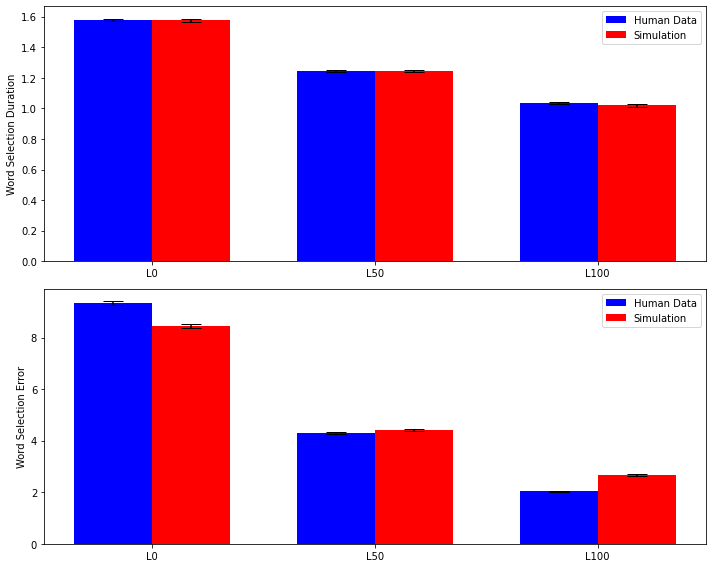

In [30]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['L0', 'L50', 'L100']

# Calculate SEM
def sem(data):
    return np.std(data) / np.sqrt(len(data))

# Using the average results for the test set
mean_human_test_duration = [np.mean(human_test_durations_copy[label]) for label in labels]
sem_human_test_duration = [sem(human_test_durations_copy[label]) for label in labels]

mean_human_test_error = [np.mean(human_test_errors_copy[label]) for label in labels]
sem_human_test_error = [sem(human_test_errors_copy[label]) for label in labels]

# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[iteration]

# Now recompute the mean and sem for these adjusted simulated results
mean_simulated_duration = [np.mean(simulated_durations_copy[label]) for label in labels]
sem_simulated_duration = [sem(simulated_durations_copy[label]) for label in labels]

mean_simulated_error = [np.mean(simulated_errors_copy[label]) for label in labels]
sem_simulated_error = [sem(simulated_errors_copy[label]) for label in labels]

# Update the plotting logic
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot for Duration
rects1 = ax[0].bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=sem_human_test_duration, capsize=10)
rects2 = ax[0].bar(x + width/2, mean_simulated_duration, width, label='Simulation', color='red', yerr=sem_simulated_duration, capsize=10)

# Plot for Error
rects3 = ax[1].bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=sem_human_test_error, capsize=10)
rects4 = ax[1].bar(x + width/2, mean_simulated_error, width, label='Simulation', color='red', yerr=sem_simulated_error, capsize=10)

# Labels, title, and custom x-axis tick labels
ax[0].set_ylabel('Word Selection Duration')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].set_ylabel('Word Selection Error')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

fig.tight_layout()
plt.show()


## Get data with only one iteration, like individual showcases

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Read in data
individual_data = r"C:\Users\91584\Desktop\0817_0630_selection_individual_data.csv"

individual_df = pd.read_csv(individual_data)

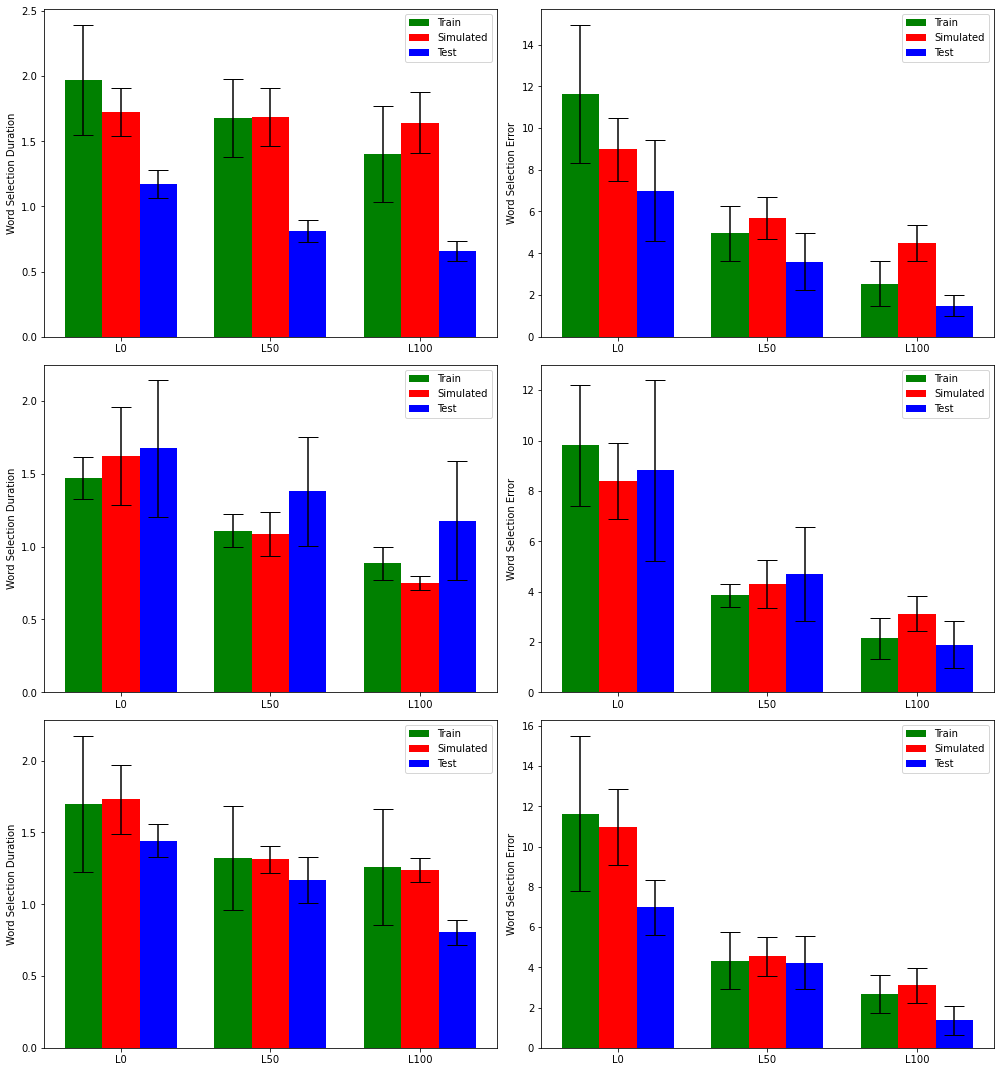

In [147]:
def extract_data(df, params, col_name, layouts):
    # Filter the dataframe based on the provided params
    for key, value in params.items():
        if isinstance(value, float):
            df = df[np.isclose(df[key], value, atol=1e-8)]
        else:
            df = df[df[key] == value]
    
    data = []
    for layout in layouts:
        subset = df[df['layout'] == layout][col_name].tolist()
        data.append(subset)
    return data

def calculate_mean_and_sem(data):
    means = [np.mean(d) for d in data]
    sems = [np.std(d) / np.sqrt(len(d)) for d in data]
    return means, sems

def plot_iteration(iteration_index):
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    
    labels = ['L0', 'L50', 'L100']
    x = np.arange(len(labels))
    width = 0.25

    for i in range(3):
        iteration_index = i
        
        train_durations = [human_train_durations_details_copy[label][iteration_index] for label in labels]
        mean_train_duration, sem_train_duration = calculate_mean_and_sem(train_durations)
        
        test_durations = [human_test_durations_details_copy[label][iteration_index] for label in labels]
        mean_test_duration, sem_test_duration = calculate_mean_and_sem(test_durations)
        
        sim_durations = extract_data(individual_df, all_best_params[iteration_index], 'steps', layouts)
        adjusted_sim_durations = [[item * sim_to_real_ratios_duration[iteration_index] for item in sublist] for sublist in sim_durations]
        mean_sim_duration, sem_sim_duration = calculate_mean_and_sem(adjusted_sim_durations)
        
        train_errors = [human_train_errors_details_copy[label][iteration_index] for label in labels]
        mean_train_error, sem_train_error = calculate_mean_and_sem(train_errors)
        
        test_errors = [human_test_errors_details_copy[label][iteration_index] for label in labels]
        mean_test_error, sem_test_error = calculate_mean_and_sem(test_errors)
        
        sim_errors = extract_data(individual_df, all_best_params[iteration_index], 'error', layouts)
        adjusted_sim_errors = [[item * sim_to_real_ratios_error[iteration_index] for item in sublist] for sublist in sim_errors]
        mean_sim_error, sem_sim_error = calculate_mean_and_sem(adjusted_sim_errors)
        
        # Duration plots
        axs[i, 0].bar(x - width, mean_train_duration, width, label='Train', color='green', yerr=sem_train_duration, capsize=10)
        axs[i, 0].bar(x, mean_sim_duration, width, label='Simulated', color='red', yerr=sem_sim_duration, capsize=10)
        axs[i, 0].bar(x + width, mean_test_duration, width, label='Test', color='blue', yerr=sem_test_duration, capsize=10)
        
        axs[i, 0].set_ylabel('Word Selection Duration')
        axs[i, 0].set_xticks(x)
        axs[i, 0].set_xticklabels(labels)
        axs[i, 0].legend()

        # Error plots
        axs[i, 1].bar(x - width, mean_train_error, width, label='Train', color='green', yerr=sem_train_error, capsize=10)
        axs[i, 1].bar(x, mean_sim_error, width, label='Simulated', color='red', yerr=sem_sim_error, capsize=10)
        axs[i, 1].bar(x + width, mean_test_error, width, label='Test', color='blue', yerr=sem_test_error, capsize=10)
        
        axs[i, 1].set_ylabel('Word Selection Error')
        axs[i, 1].set_xticks(x)
        axs[i, 1].set_xticklabels(labels)
        axs[i, 1].legend()

    fig.tight_layout()
    plt.show()

# Plot for iteration 3
plot_iteration(3)